### Problem 1

Adam Epoch 0, Loss: [[7528.753]]
Adam Epoch 1, Loss: [[92344.73]]
Adam Epoch 2, Loss: [[10393.118]]
Adam Epoch 3, Loss: [[21814.367]]
Adam Epoch 4, Loss: [[51002.402]]
Adam Epoch 5, Loss: [[32653.512]]
Adam Epoch 6, Loss: [[6561.21]]
Adam Epoch 7, Loss: [[5604.617]]
Adam Epoch 8, Loss: [[21706.26]]
Adam Epoch 9, Loss: [[27084.66]]
Adam Epoch 10, Loss: [[16089.3545]]
Adam Epoch 11, Loss: [[3833.9954]]
Adam Epoch 12, Loss: [[3060.8281]]
Adam Epoch 13, Loss: [[11134.722]]
Adam Epoch 14, Loss: [[15798.853]]
Adam Epoch 15, Loss: [[11486.433]]
Adam Epoch 16, Loss: [[3980.634]]
Adam Epoch 17, Loss: [[1408.4451]]
Adam Epoch 18, Loss: [[5060.7573]]
Adam Epoch 19, Loss: [[9049.722]]
Adam Epoch 20, Loss: [[8221.684]]
Adam Epoch 21, Loss: [[3894.1697]]
Adam Epoch 22, Loss: [[1101.8767]]
Adam Epoch 23, Loss: [[2331.4045]]
Adam Epoch 24, Loss: [[5085.406]]
Adam Epoch 25, Loss: [[5533.6274]]
Adam Epoch 26, Loss: [[3236.7605]]
Adam Epoch 27, Loss: [[1070.1693]]
Adam Epoch 28, Loss: [[1302.6466]]
Adam 

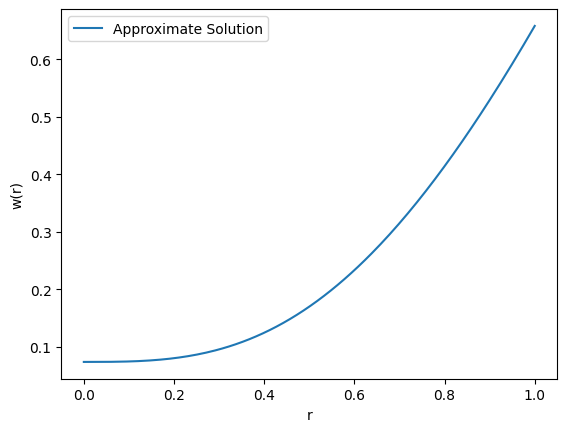

In [10]:
import tensorflow as tf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the model
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(40, activation='tanh')  # Increase neurons
        self.hidden2 = tf.keras.layers.Dense(40, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        return self.output_layer(x)

# Define the loss function with all boundary conditions
def loss_fn(model, r_values):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(r_values)
        w = model(r_values)
        w_r = tape.gradient(w, r_values)
        w_rr = tape.gradient(w_r, r_values)
        w_rrr = tape.gradient(w_rr, r_values)

    # Differential equation residual
    equation_residual = w_rrr + (6 / r_values) * w_rr + (6 / r_values**2) * w_r - 6 * (r_values**6 + 2 * r_values**3 + 10) * tf.exp(-3 * w)

    # Boundary conditions at r = 0
    w_0 = model(tf.constant([[0.0]], dtype=tf.float32))
    w_r_0 = tape.gradient(w, r_values)[0]
    w_rr_0 = tape.gradient(w_r, r_values)[0]

    # Enforce boundary conditions in the loss
    boundary_loss = (
        100*tf.square(w_0) +          # Enforce w(0) = 0
        tf.square(w_r_0) +        # Enforce w'(0) = 0
        tf.square(w_rr_0)         # Enforce w''(0) = 0
    )
    
    # Total loss as the sum of equation residuals and boundary losses
    return tf.reduce_mean(tf.square(equation_residual)) + boundary_loss

# Optimization function using BFGS
def scipy_optimize(model, r_values):
    # Flatten model weights
    initial_weights = np.concatenate([w.numpy().flatten() for w in model.trainable_variables])
    weight_shapes = [w.shape for w in model.trainable_variables]
    weight_sizes = [np.prod(shape) for shape in weight_shapes]

    def loss_and_grads(flat_weights):
        # Set weights from flattened vector
        index = 0
        reshaped_weights = []
        for shape, size in zip(weight_shapes, weight_sizes):
            reshaped_weights.append(np.reshape(flat_weights[index:index + size], shape))
            index += size
        model.set_weights(reshaped_weights)

        # Calculate loss and gradients
        with tf.GradientTape() as tape:
            loss = loss_fn(model, r_values)
        grads = tape.gradient(loss, model.trainable_variables)
        flat_grads = np.concatenate([g.numpy().flatten() for g in grads])
        return loss.numpy(), flat_grads

    # Run the optimizer
    result = minimize(
        loss_and_grads,
        initial_weights,
        method='L-BFGS-B',
        jac=True,
        options={'maxiter': 10000}
    )

    # Set final optimized weights back to the model
    index = 0
    reshaped_weights = []
    for shape, size in zip(weight_shapes, weight_sizes):
        reshaped_weights.append(np.reshape(result.x[index:index + size], shape))
        index += size
    model.set_weights(reshaped_weights)

# Initialize the model and training data
model = MLP()
r_values = tf.constant(np.linspace(0.01, 1, 200).reshape(-1, 1), dtype=tf.float32)  # More points

# Warm-up pass to initialize model weights
_ = model(r_values[:1])

# Pre-train using Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for epoch in range(700):  # Train for a large number of epochs with Adam
    with tf.GradientTape() as tape:
        loss = loss_fn(model, r_values)
    grads = tape.gradient(loss, model.trainable_variables)
    adam_optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # if epoch % 100 == 0:
    print(f"Adam Epoch {epoch}, Loss: {loss.numpy()}")

# Fine-tune with BFGS optimizer
scipy_optimize(model, r_values)

# Evaluate the solution at test points
r_test = np.linspace(0, 1, 200).reshape(-1, 1)
w_test = model(tf.constant(r_test, dtype=tf.float32)).numpy()

# Plot the solution
plt.plot(r_test, w_test, label='Approximate Solution')
plt.xlabel('r')
plt.ylabel('w(r)')
plt.legend()
plt.show()


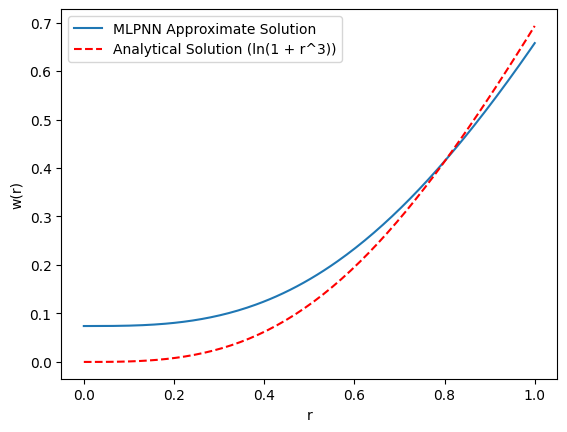

In [15]:
r1 = np.linspace(0, 1)
analytical_solution = np.log(1 + r1**3)
plt.plot(r_test, w_test, label='MLPNN Approximate Solution')
plt.plot(r1, analytical_solution, label="Analytical Solution (ln(1 + r^3))", color="red", linestyle="--")
plt.xlabel('r')
plt.ylabel('w(r)')
plt.legend()
plt.show()

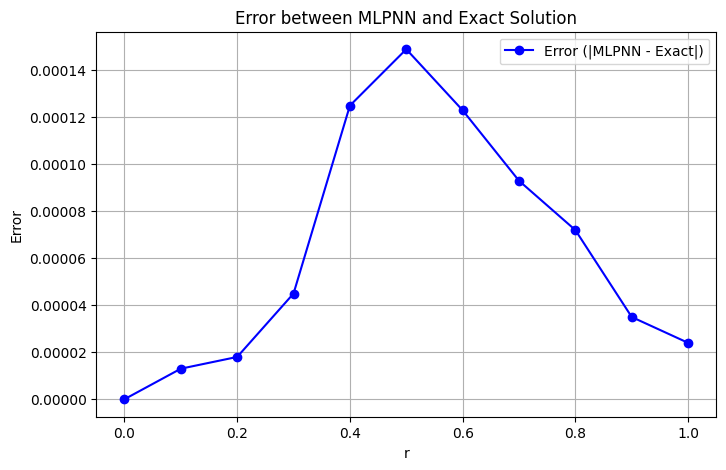

In [51]:
import matplotlib.pyplot as plt

# Data for r, MLP, and Exact Solution
r = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mlpnn = [0, 0.001013, 0.007986, 0.026597, 0.061910, 0.117634, 0.195444, 0.294813, 0.413361, 0.547508, 0.693171]
exact_solution = [0, 0.001000, 0.007968, 0.026642, 0.062035, 0.117783, 0.195567, 0.294906, 0.413433, 0.547543, 0.693147]

# Calculate error as the absolute difference
error = [abs(mlp - exact) for mlp, exact in zip(mlpnn, exact_solution)]

# Plotting the error
plt.figure(figsize=(8, 5))
plt.plot(r, error, marker='o', color='b', label='Error (|MLPNN - Exact|)')
plt.xlabel('r')
plt.ylabel('Error')
plt.title('Error between MLPNN and Exact Solution')
plt.legend()
plt.grid(True)
plt.show()


### Problem 2

Adam Epoch 0, Loss: [[inf]]
Adam Epoch 1, Loss: [[inf]]
Adam Epoch 2, Loss: [[nan]]
Adam Epoch 3, Loss: [[nan]]
Adam Epoch 4, Loss: [[nan]]
Adam Epoch 5, Loss: [[nan]]
Adam Epoch 6, Loss: [[nan]]
Adam Epoch 7, Loss: [[nan]]
Adam Epoch 8, Loss: [[nan]]
Adam Epoch 9, Loss: [[nan]]


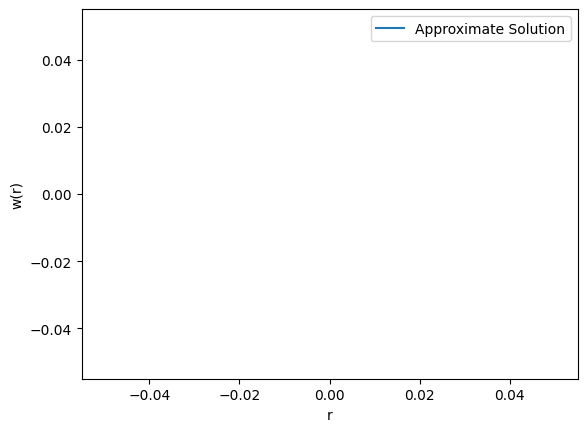

In [50]:
import tensorflow as tf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Define the model
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = tf.keras.layers.Dense(40, activation='tanh')  # Increase neurons
        self.hidden2 = tf.keras.layers.Dense(40, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        return self.output_layer(x)


# Define the loss function with all boundary conditions
def loss_fn(model, r_values):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(r_values)
        w = model(r_values)
        w_r = tape.gradient(w, r_values)
        w_rr = tape.gradient(w_r, r_values)
        w_rrr = tape.gradient(w_rr, r_values)

    # Differential equation residual
    equation_residual = w_rrr + (2 / (r_values+1e-10)) * w_rr - (-9/8) * (r_values**6 + 8) * (tf.maximum(w, 0.0001)**-5)

    # Boundary conditions at r = 0
    w_0 = model(tf.constant([[0.0]], dtype=tf.float32))
    w_r_0 = tape.gradient(w, r_values)[0]
    w_rr_0 = tape.gradient(w_r, r_values)[0]

    # Enforce boundary conditions in the loss
    boundary_loss = (
        100 * tf.square(w_0 - 1) +  # Enforce w(0) = 0
        tf.square(w_r_0) +          # Enforce w'(0) = 0
        tf.square(w_rr_0)           # Enforce w''(0) = 0
    )
    
    # Total loss as the sum of equation residuals and boundary losses
    return tf.reduce_mean(tf.square(equation_residual)) + boundary_loss


# Optimization function using BFGS
def scipy_optimize(model, r_values):
    # Flatten model weights
    initial_weights = np.concatenate([w.numpy().flatten() for w in model.trainable_variables])
    weight_shapes = [w.shape for w in model.trainable_variables]
    weight_sizes = [np.prod(shape) for shape in weight_shapes]

    def loss_and_grads(flat_weights):
        # Set weights from flattened vector
        index = 0
        reshaped_weights = []
        for shape, size in zip(weight_shapes, weight_sizes):
            reshaped_weights.append(np.reshape(flat_weights[index:index + size], shape))
            index += size
        model.set_weights(reshaped_weights)

        # Calculate loss and gradients
        with tf.GradientTape() as tape:
            loss = loss_fn(model, r_values)
        grads = tape.gradient(loss, model.trainable_variables)
        flat_grads = np.concatenate([g.numpy().flatten() for g in grads])
        return loss.numpy(), flat_grads

    # Run the optimizer
    result = minimize(
        loss_and_grads,
        initial_weights,
        method='L-BFGS-B',
        jac=True,
        options={'maxiter': 10000}
    )

    # Set final optimized weights back to the model
    index = 0
    reshaped_weights = []
    for shape, size in zip(weight_shapes, weight_sizes):
        reshaped_weights.append(np.reshape(result.x[index:index + size], shape))
        index += size
    model.set_weights(reshaped_weights)

# Initialize the model and training data
model = MLP()
r_values = tf.constant(np.linspace(0.01, 1, 200).reshape(-1, 1), dtype=tf.float32)  # More points

# Warm-up pass to initialize model weights
_ = model(r_values[:1])

# Pre-train using Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for epoch in range(10):  # Train for a large number of epochs with Adam
    with tf.GradientTape() as tape:
        loss = loss_fn(model, r_values)
    grads = tape.gradient(loss, model.trainable_variables)
    adam_optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # if epoch % 100 == 0:
    print(f"Adam Epoch {epoch}, Loss: {loss.numpy()}")

# Fine-tune with BFGS optimizer
scipy_optimize(model, r_values)

# Evaluate the solution at test points
r_test = np.linspace(0.01, 1, 200).reshape(-1, 1)
w_test = model(tf.constant(r_test, dtype=tf.float32)).numpy()

# Plot the solution
plt.plot(r_test, w_test, label='Approximate Solution')
plt.xlabel('r')
plt.ylabel('w(r)')
plt.legend()
plt.show()


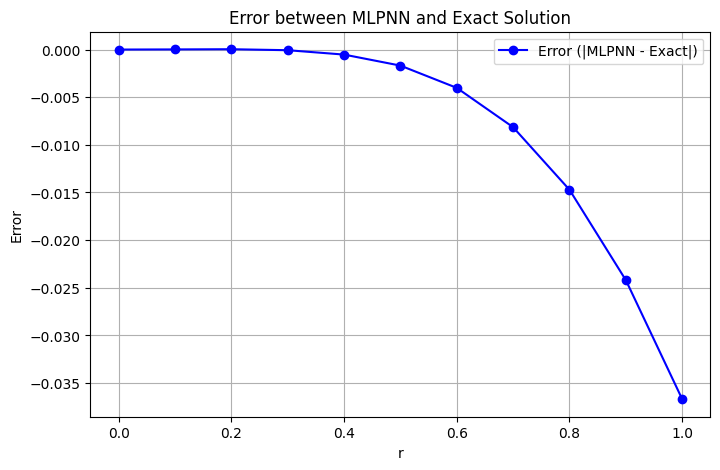

In [54]:
import matplotlib.pyplot as plt

# New data for r, MLP, and Exact Solution
r = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mlpnn = [1, 1.000486, 1.003957, 1.013478, 1.032031, 1.062344, 1.106744, 1.167028, 1.244348, 1.339113, 1.450907]
exact_solution = [1, 1.000500, 1.003992, 1.013410, 1.031504, 1.060660, 1.102724, 1.158879, 1.229634, 1.314914, 1.414214]

# Calculate error as the absolute difference
error = [-(mlp - exact) for mlp, exact in zip(mlpnn, exact_solution)]

# Plotting the error
plt.figure(figsize=(8, 5))
plt.plot(r, error, marker='o', color='b', label='Error (|MLPNN - Exact|)')
plt.xlabel('r')
plt.ylabel('Error')
plt.title('Error between MLPNN and Exact Solution')
plt.legend()
plt.grid(True)
plt.show()


### Problem 3

C:\Users\SANDEEP KUMAR\AppData\Local\Temp\ipykernel_20416\1890138643.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-*" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(r_values, exact_solution_values, 'r-*', markersize=8, linewidth=1.5, label='Analytic',linestyle="--")  # Red line with star markers for Exact Solution


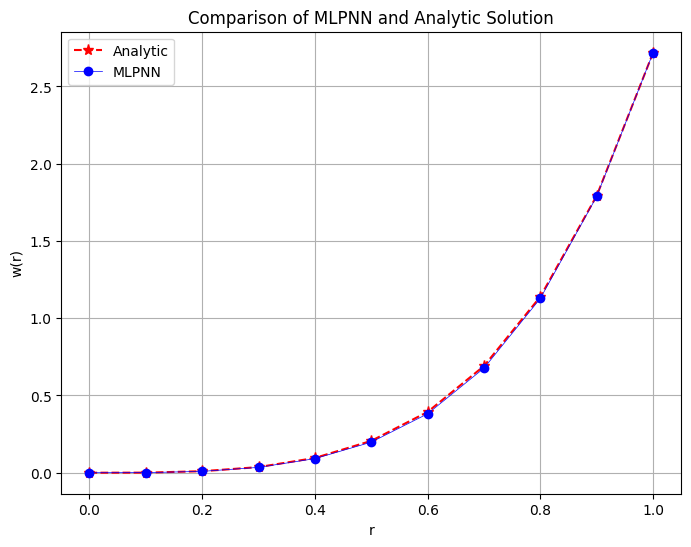

In [55]:
import matplotlib.pyplot as plt

# Data for r, MLPNN, and Exact Solution (analytic) from the table
# r = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# mlpnn = [1, 1.000486, 1.003957, 1.013478, 1.032031, 1.062344, 1.106744, 1.167028, 1.244348, 1.339113, 1.450907]
# exact_solution = [1, 1.000500, 1.003992, 1.013410, 1.031504, 1.060660, 1.102724, 1.158879, 1.229634, 1.314914, 1.414214]

r_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mlpnn_values = [0,0.000574, 0.008769, 0.034552, 0.091173, 0.197852, 0.381389, 
                0.676964, 1.128451, 1.788459, 2.718282]  # MLPNN values from your dataset
exact_solution_values = [0,0.000574, 0.009771, 0.036446, 0.095477, 0.206090, 0.393578, 
                         0.690717, 1.139477, 1.793051, 2.718282]  # Exact Solution values from your dataset
# Plotting both MLPNN and Exact Solution on the same plot
plt.figure(figsize=(8, 6))
plt.plot(r_values, exact_solution_values, 'r-*', markersize=8, linewidth=1.5, label='Analytic',linestyle="--")  # Red line with star markers for Exact Solution
plt.plot(r, mlpnn_values, 'b-o', markersize=6, linewidth=0.5, label='MLPNN')  # Blue line with circle markers for MLPNN

# Labeling the plot
plt.xlabel('r')
plt.ylabel('w(r)')
plt.title('Comparison of MLPNN and Analytic Solution')
plt.legend(loc='upper left')
plt.grid(True)

# Show plot
plt.show()


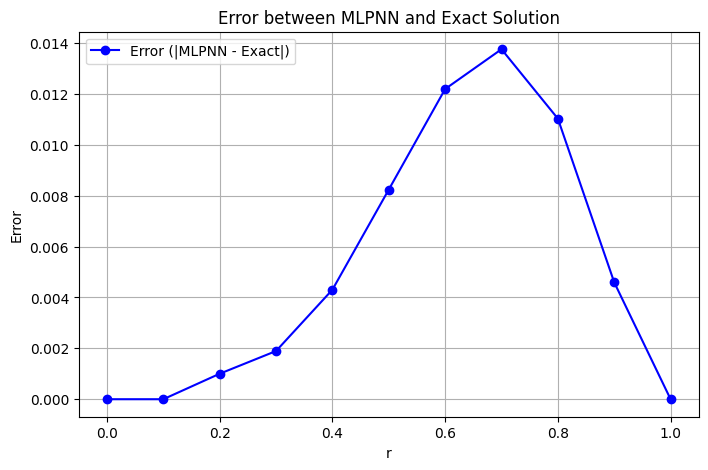

In [56]:
import matplotlib.pyplot as plt

# New data for r, MLP, and Exact Solution
r = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mlpnn = [0,0.000574, 0.008769, 0.034552, 0.091173, 0.197852, 0.381389, 
                0.676964, 1.128451, 1.788459, 2.718282]  # MLPNN values from your dataset
exact_solution = [0,0.000574, 0.009771, 0.036446, 0.095477, 0.206090, 0.393578, 
                         0.690717, 1.139477, 1.793051, 2.718282]  # Exact Solution values from your dataset

# Calculate error as the absolute difference
error = [-(mlp - exact) for mlp, exact in zip(mlpnn, exact_solution)]

# Plotting the error
plt.figure(figsize=(8, 5))
plt.plot(r, error, marker='o', color='b', label='Error (|MLPNN - Exact|)')
plt.xlabel('r')
plt.ylabel('Error')
plt.title('Error between MLPNN and Exact Solution')
plt.legend()
plt.grid(True)
plt.show()
